In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastdate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
lastdate

'2017-08-23'

In [11]:
# Calculate the date 1 year ago from lastday
firstdate=str(int(lastdate[0:4])-1) + lastdate[4:]
firstdate

'2016-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, func.avg(Measurement.prcp))\
.filter(Measurement.date > firstdate)\
.order_by(Measurement.date)\
.group_by(Measurement.date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result, columns=['date','prcp'])
df.head()

,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


In [14]:
# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")
df.set_index('date',inplace=True)
df.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<IPython.core.display.Javascript object>


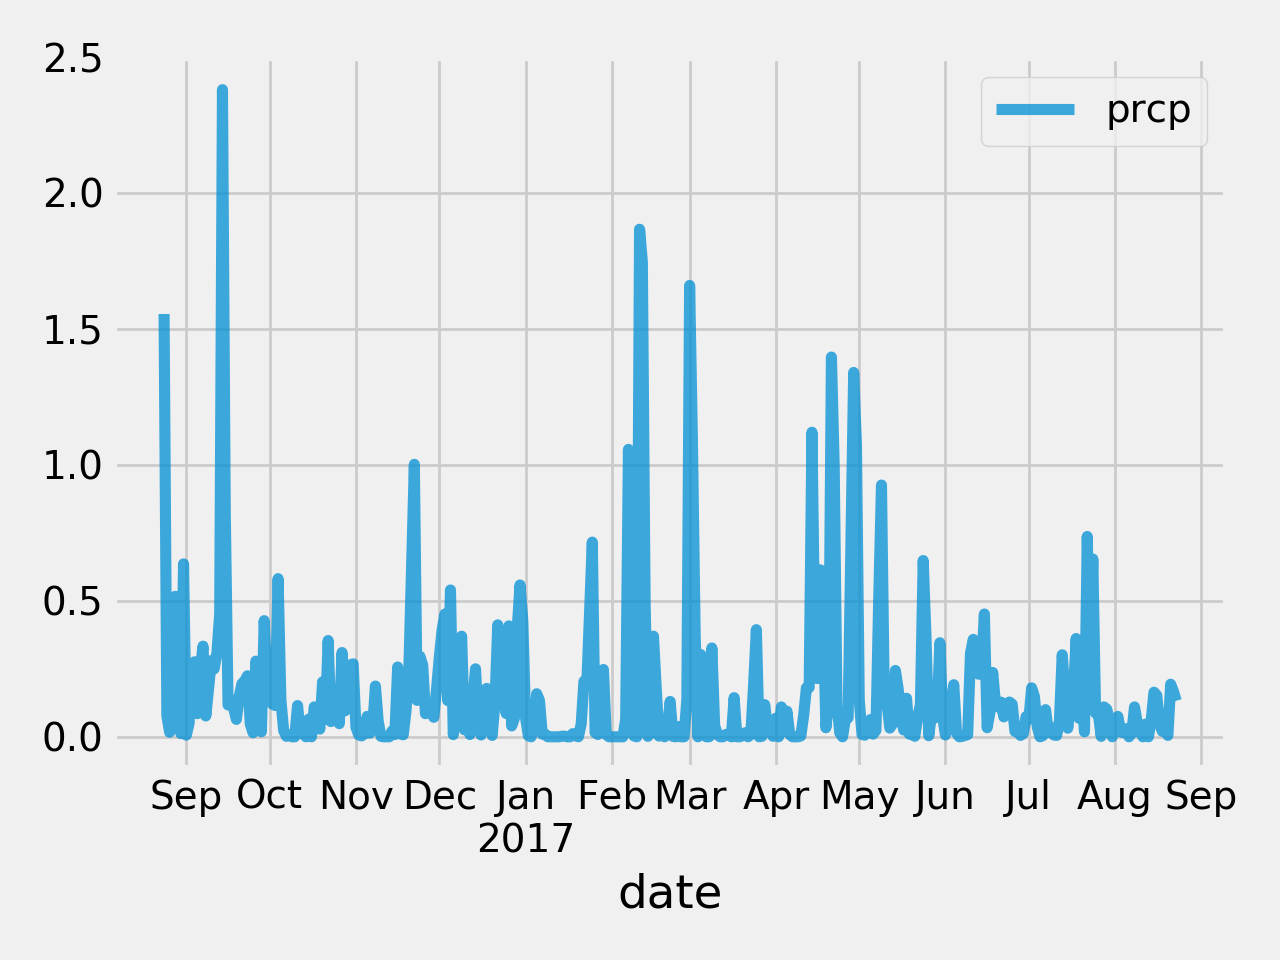

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y='prcp',alpha=0.75)
plt.tight_layout()
# Rotate the xticks for the dates

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [17]:
# How many stations are available in this dataset?
session.query(Station).count()

9

In [18]:
stations = session.query(Station)
for station in stations:
    print(station.name)

WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
results = [row for row in session.execute('Select station, count(1) as c from measurement group by station order by c desc')]
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
[row for row in session.execute(f'Select min(tobs), max(tobs), avg(tobs) from measurement where station = "{results[0][0]}"')]

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


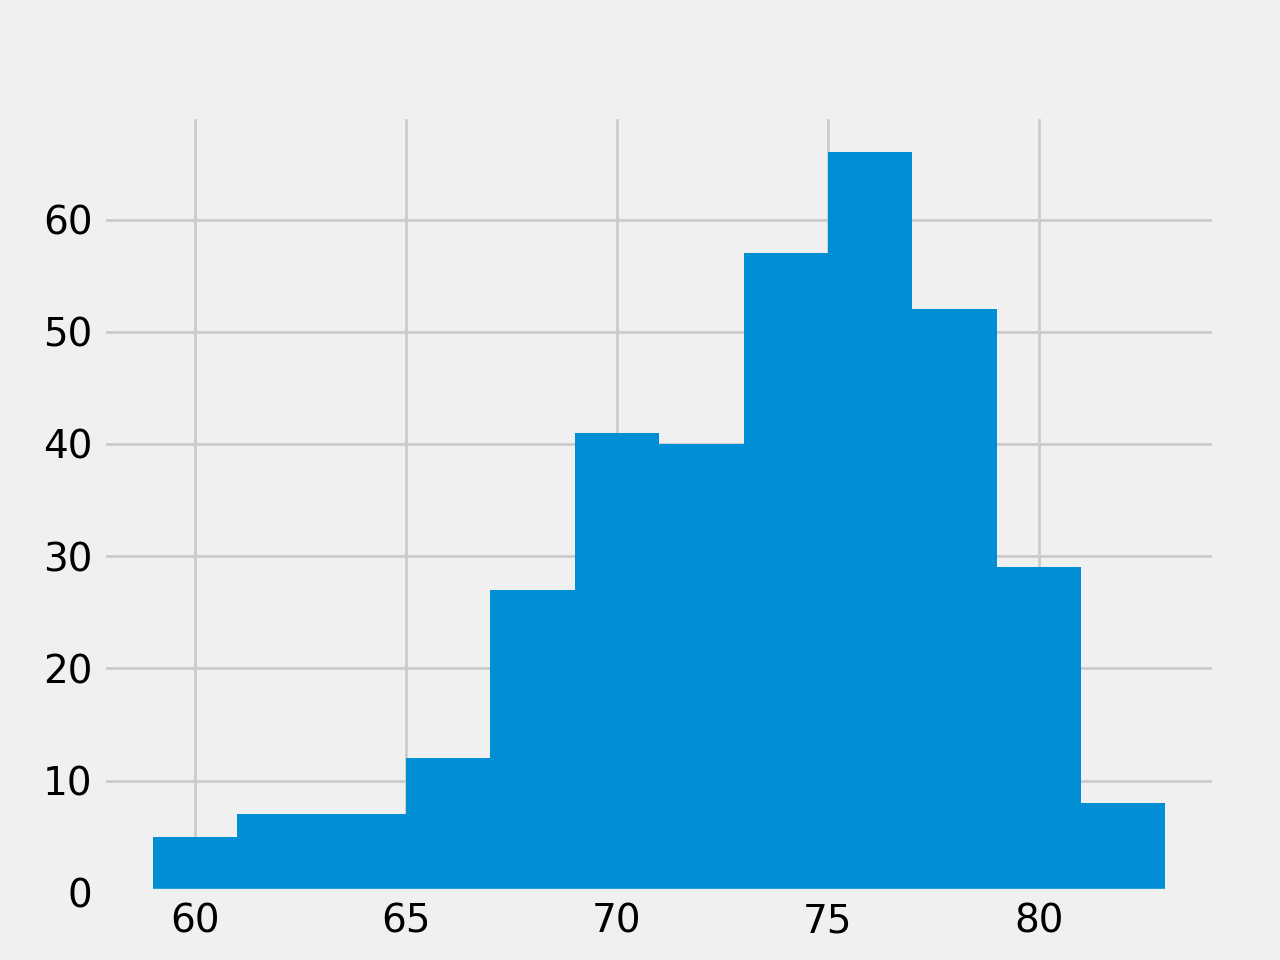

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results2 = session.query(Measurement.tobs).filter_by(station=results[0][0]).filter(Measurement.date > firstdate).all()
plt.figure()
plt.hist([result[0] for result in results2],bins=12)
plt.show()

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28','2011-02-28'))

[(65.0, 69.66666666666667, 75.0)]


In [24]:
results = calc_temps('2011-02-28','2011-03-05')

<IPython.core.display.Javascript object>


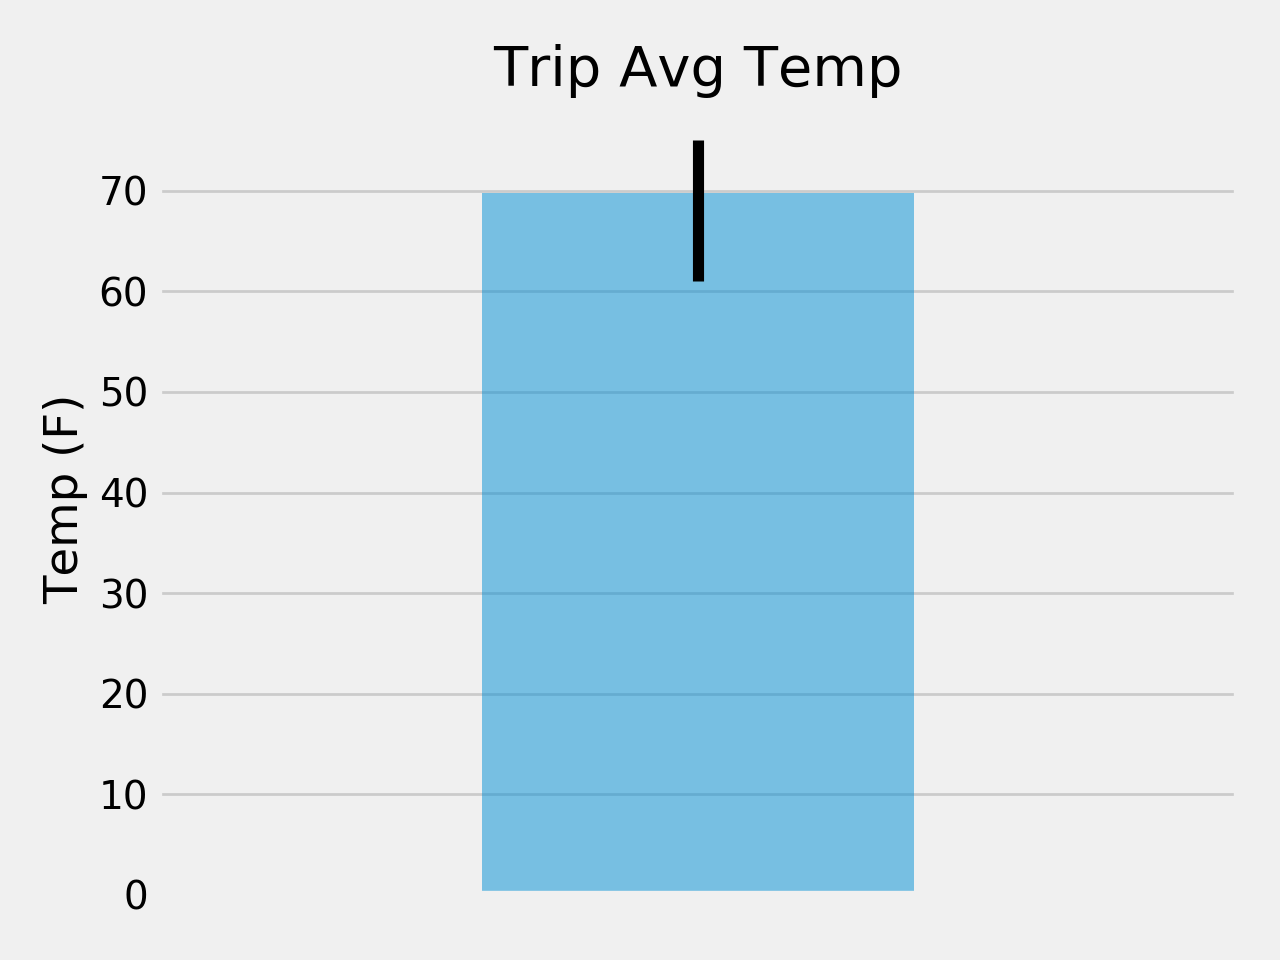

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure()
plt.bar([1],results[0][1], yerr = [[results[0][1]-results[0][0]],[results[0][2]-results[0][1]]], alpha = 0.5)
plt.xlim(0,2)
plt.xticks([])
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
date0,date1 = '2011-02-28','2011-03-05'
result = session.execute(f'Select measurement.station, station.name, station.latitude, station.longitude, station.elevation, avg(measurement.prcp) as a from station join measurement on station.station = measurement.station where measurement.date >= "{date0}" and measurement.date <="{date1}" group by measurement.station order by a desc')
[row for row in result]


[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
